In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import math

## Multiresolution Hash encoding

In nerf-ngp they show that hash encoding is allowing us to speed up conversion of nerf model.  
Here we will take apart multiresolution hash encoding and see how it works from inside, and implement our own encoding class.

In [2]:
# Our dummy input represents one point in [near, far] bounding space
# dummy_input = torch.tensor([[-1., -2., 3]]) # 3D
dummy_input = torch.tensor([[-1., 3.]]) # 2D

# Normalizing our input by bounding distance
far=6
near=2
bound_distance = far - near

norm_dummy_input = (bound_distance - dummy_input) / (2 * bound_distance)
print(norm_dummy_input)


tensor([[0.6250, 0.1250]])


We will separate this encoding on next parts:  
-  Generating hash table
- Writing HashGridEncoding class

### Generating hash table

In [3]:
# Here we define parameters for our future enncoding

# Theoreticly we can encode as many dimentions as many primes we have
PRIMES = [1, 2654435761, 805459861, 3674653429, 2097192037, 1434869437, 2165219737]

# Number of different resolution levels,
# each one will have finer grid 
n_levels = 3

# Maximum and minimum resulutions for levels
coarsest_resolution = 16
finest_resolution = 512 # from 512 to 524288

# Number of feature dimensions per one data point
# For 2D is 2; For 3D is 3; and so on... ???
n_dim_per_resolution = 2

# Max hash table size for each level 
max_entries_per_level = 2**14 # from 2^14 to 2^24


In [4]:
# First we compute resolutions for each level
# This is geometric progression between 
# coarsest_resolution and finest_resolution

resolutions = []

b = math.log(finest_resolution) - math.log(coarsest_resolution)

for level in range(1, n_levels+1):
    b_factor = math.floor(math.exp(b / (level)))
    level_resolution = coarsest_resolution * b_factor
    resolutions.append(level_resolution)
resolutions

[512, 80, 48]

In [41]:
def get_box_corners_2d(inputs, coarsest_resolution):
    box_index = inputs // coarsest_resolution
    box_coordinates_1 = box_index[0] * coarsest_resolution
    box_coordinates_2 = box_index[0] * coarsest_resolution+coarsest_resolution
    
    coordinates = [
        [box_coordinates_1[0], box_coordinates_1[1]],
        [box_coordinates_2[0], box_coordinates_2[1]],
        [box_coordinates_1[0], box_coordinates_2[1]],
        [box_coordinates_2[0], box_coordinates_1[1]]
    ]
    return np.array(coordinates).astype(int)



512 [[240 496]
 [256 512]
 [240 512]
 [256 496]]


/home/ivan/miniconda3/envs/dnerf/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  


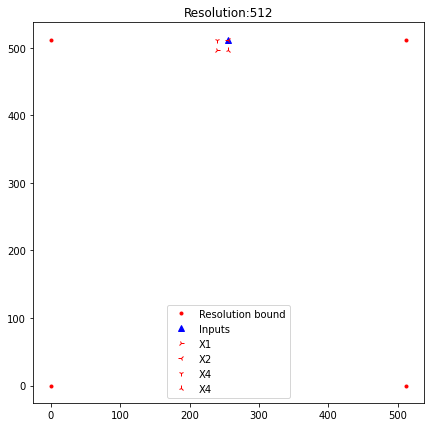

80 [[32 64]
 [48 80]
 [32 80]
 [48 64]]


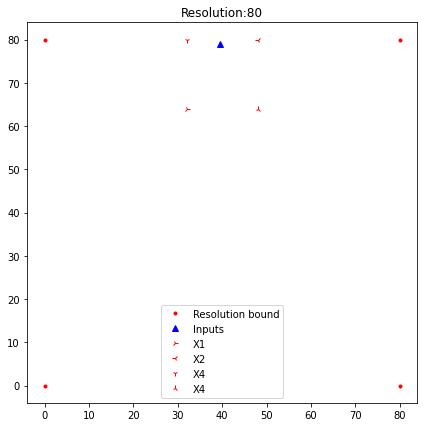

48 [[16 32]
 [32 48]
 [16 48]
 [32 32]]


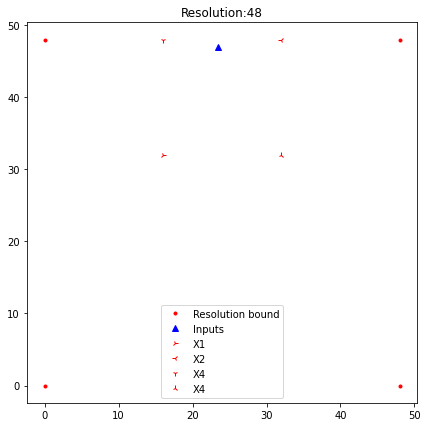

In [42]:
# Imagene we have a test 2D input
# we go through every resolution we have
# and finding corner coordinated of a box that surraunds input.
# See get_box_corners_2d() 

test_input = torch.tensor([[0.5,1.]])

for resolution in resolutions:
    # LOGIC
    inputs = test_input * (resolution-1)
    coords = get_box_corners_2d(inputs, coarsest_resolution)
    print(resolution, coords)
    # PLOTTING
    fig, ax = plt.subplots(figsize=(7,7))
    ax.set_title('Resolution:'+str(resolution))

    # Plot resolution box
    ax.plot([0,0,resolution,resolution], [0,resolution,0,resolution], 'r.',
    label='Resolution bound')

    # Input
    ax.plot(inputs[0,0], inputs[0,1], 'b^', label='Inputs')

    ax.plot(coords[0,0], coords[0,1], 'r4', label='X1')
    ax.plot(coords[1,0], coords[1,1], 'r3', label='X2')
    ax.plot(coords[2,0], coords[2,1], 'r1', label='X4')
    ax.plot(coords[3,0], coords[3,1], 'r2', label='X4')

    plt.legend()
    plt.show()
    

In [43]:
def get_box_corners_3d(inputs, coarsest_resolution):
    box_index = inputs // coarsest_resolution
    c1 = box_index[0] * coarsest_resolution
    c2 = box_index[0] * coarsest_resolution+coarsest_resolution
    
    coordinates = [
        # Top square
        [c1[0], c1[1], c2[2]],
        [c2[0], c2[1], c2[2]],
        [c1[0], c2[1], c2[2]],
        [c2[0], c1[1], c2[2]],
        # Bottom square
        [c1[0], c1[1], c1[2]],
        [c2[0], c2[1], c1[2]],
        [c1[0], c2[1], c1[2]],
        [c2[0], c1[1], c1[2]],
    ]
    return np.array(coordinates).astype(int)



/home/ivan/miniconda3/envs/dnerf/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  


NameError: name 'c1' is not defined

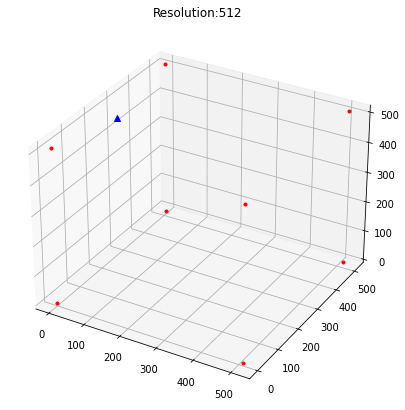

In [44]:
# Imagene we have a test 3D input
# we go through every resolution we have
# and finding corner coordinated of a box that surraunds input.
# See get_box_corners_2d() 

test_input = torch.tensor([[0.1,0.4, 1.0]])

for resolution in resolutions:
    # LOGIC
    inputs = test_input * (resolution-1)
    
    
    c = get_box_corners_3d(inputs, coarsest_resolution)

    # PLOTTING
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(projection='3d')
    ax.set_title('Resolution:'+str(resolution))

    # Plot resolution box
    ax.plot(
        [0,0,0,0,resolution,resolution,resolution,resolution], 
        [0,resolution,0,resolution,0,resolution,0,resolution],
        [0,0,resolution,resolution,0,0,resolution,resolution],
        'r.',
        label='Resolution bound')

    # Input
    ax.plot(
        inputs[0,0], 
        inputs[0,1],
        inputs[0,2],
        'b^', 
        label='Inputs')
    print(resolution, c1,c2)
    ax.plot(c[0,0], c[0,1], c[0,2], 'r1', label='X1top')
    ax.plot(c[1,0], c[1,1], c[1,2], 'r1', label='X2top')
    ax.plot(c[2,0], c[2,1], c[2,2], 'r1', label='X3top')
    ax.plot(c[3,0], c[3,1], c[3,2], 'r1', label='X4top')

    ax.plot(c[4,0], c[4,1], c[4,2], 'r2', label='X1bot')
    ax.plot(c[5,0], c[5,1], c[5,2], 'r2', label='X2bot')
    ax.plot(c[6,0], c[6,1], c[6,2], 'r2', label='X3bot')
    ax.plot(c[7,0], c[7,1], c[7,2], 'r2', label='X4bot')

    plt.legend()
    plt.show()
    

In [88]:
# Making parametric hash table
# that will contain embeddings for each corner of hypercube
# Our text encoding will be just arange form 1 to table_size

# 1
hash_table = []#nn.ParameterList([])
for resolution in resolutions:
    total_resolution = resolution ** n_dim_per_resolution
    table_size = int(min(total_resolution, max_entries_per_level))
    table = torch.zeros((table_size, n_dim_per_resolution))
    table = torch.range(0,table.shape[0]+1).repeat(2,1).T
    # table = nn.Parameter(table)
    hash_table.append(table)
# hash_table


/home/ivan/miniconda3/envs/dnerf/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  # This is added back by InteractiveShellApp.init_path()


In [99]:
test_input = torch.tensor([[0.5,1.]])

for level, resolution in enumerate(resolutions):
    # LOGIC
    inputs = test_input * (resolution-1)
    corners_coords = get_box_corners_2d(inputs, coarsest_resolution)

    # print(inputs, coords)

    # HASH
    _sum = 0
    for i in range(n_dim_per_resolution):
        _sum = _sum ^ (corners_coords[..., i] * PRIMES[i])
        print(_sum)
    index = _sum % max_entries_per_level
    index = torch.tensor(index).to(torch.long).flatten()

    # Get Hash features
    level_hash_table = hash_table[level]
    corners_features = level_hash_table[index]

    


    break


[240 256 240 256]
[1316600137216 1359071109888 1359071109872 1316600137712]


/home/ivan/miniconda3/envs/dnerf/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  


In [102]:
level_hash_table[index]

tensor([[1536., 1536.],
        [8960., 8960.],
        [8944., 8944.],
        [2032., 2032.]])

In [97]:
corners_coords.shape
corners_features.reshape(
    corners_coords.shape[0], 
    corners_coords.shape[1],
    n_dim_per_resolution)


RuntimeError: shape '[4, 2, 2]' is invalid for input of size 8

In [90]:
torch.reshape(self.hashtable[lvl][flat_feature_index],
(corners.shape[0], corners.shape[1], self.feature_dim))
weights = self.interpolation_weights(coord - floor_corner)

(tensor([[1536., 1536.],
         [8960., 8960.],
         [8944., 8944.],
         [2032., 2032.]]),
 tensor([1536, 8960, 8944, 2032]))

In [ ]:
print(resolution)
# LOGIC
input_down = torch.floor(test_input * resolution)
input_up = torch.ceil(test_input * resolution)
# floor_corner = torch.clip(test_input * (resolution - 1), 0, resolution - 1.0001)
# box_corners = get_corner(floor_corner, resolution)




# Input
ax.plot(input_down[0,0], input_down[0,1], 'b1', label='Down')
ax.plot(input_up[0,0], input_up[0,1], 'b2', label='Up')


plt.legend()
# for corner in corners:
# 	ax.plot(box_corners[...,0], box_corners[...,1], 'gx')

In [95]:
def get_corner(floor_corner, resolution=1):
	num_entry = floor_corner.shape[0]
	if n_dim_per_resolution == 1:
		raise NotImplementedError
	elif n_dim_per_resolution == 2:
		c000 = floor_corner
		c001 = floor_corner + torch.tensor([0, 1]).repeat(num_entry, 1)
		c010 = floor_corner + torch.tensor([1, 0]).repeat(num_entry, 1)
		c011 = floor_corner + torch.ones_like(floor_corner)
		stacks = torch.stack([c000, c010, c001, c011], -2)
		return stacks
	elif n_dim_per_resolution == 3:
		c000 = floor_corner
		c001 = floor_corner + torch.tensor([0, 0, 1]).repeat(num_entry, 1)
		c010 = floor_corner + torch.tensor([0, 1, 0]).repeat(num_entry, 1)
		c011 = floor_corner + torch.tensor([0, 1, 1]).repeat(num_entry, 1)
		c100 = floor_corner + torch.tensor([1, 0, 0]).repeat(num_entry, 1)
		c101 = floor_corner + torch.tensor([1, 0, 1]).repeat(num_entry, 1)
		c110 = floor_corner + torch.tensor([1, 1, 0]).repeat(num_entry, 1)
		c111 = floor_corner + torch.ones_like(floor_corner)
		stacks = torch.stack([c000, c010, c001, c011, c100, c101, c110, c111], -2)
		return stacks
	else:
		raise NotImplementedError

In [22]:


for resolution in resolutions:
	# corner = torch.clip(norm_dummy_input * (resolution - 1), 0, resolution - 1.0001)
	floor_corner = torch.floor(norm_dummy_input * resolution)
	corners = get_corner(floor_corner)
	print(corners)


None
None
None


In [ ]:
level_scale = self._grid_scale(
				level, 
				math.log2(self.per_level_scale), 
				self.base_resolution)

_grid_scale(self, level: int, log2_per_level_scale: float, base_resolution: int):
		# The -1 means that `base_resolution` refers to the number of grid _vertices_ rather
		# than the number of cells. This is slightly different from the notation in the paper,
		# but results in nice, power-of-2-scaled parameter grids that fit better into cache lines.
		return math.exp(level * log2_per_level_scale) * base_resolution - 1.0

In [30]:
import math 
import torch
import torch.nn as nn
import numpy as np
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
def log(msg):
	logging.debug(str(msg))

class GridEncoder(nn.Module):
	def __init__(self,
			  input_dim = 3,
			  n_levels:int = 16,
			  n_features_per_level:int = 2,
			  per_level_scale:int = 2,
			  log2_hashmap_size:int = 19,
			  base_resolution:int = 16,
			  grid_type="HASH"

			  ):
		r"""Multiresolution Grid implementation  		
		Args:  
			input_dim: dimentions of input tensor  
			n_levels: Number of levels (resolutions)  
			n_features_per_level: Dimensionality of feature vector, stored in each level's entries.  
			per_level_scale: Multiply resolution by this scale at each level  
			log2_hashmap_size: Is the base-2 logarithm of the number of elements
			base_resolution: The resolution of the coarsest level is base_resolution^input_dims
			grid_type: Type of grid. Number of parameters from small to high: [HASH, TILE, DENSE]
		Based on:   
		https://github.com/NVlabs/tiny-cuda-nn/blob/b3473c81396fe927293bdfd5a6be32df8769927c/include/tiny-cuda-nn/encodings/grid.h  
		"""
		super().__init__()
		self.input_dim = input_dim
		self.n_levels = n_levels
		self.n_features_per_level = n_features_per_level
		self.log2_hashmap_size = log2_hashmap_size
		self.base_resolution = base_resolution
		self.per_level_scale = per_level_scale
		self.grid_type = grid_type

		log('Init Grid')
		self.initialize_grid()


	def initialize_grid(self):
		log('Grid_type: '+ self.grid_type)

		offsets = []
		offset = 0
		for level in range(self.n_levels):
			# Compute number of dense params required for the given level
			level_scale = self._grid_scale(
				level, 
				math.log2(self.per_level_scale), 
				self.base_resolution)
			resolution = self._grid_resolution(level_scale)
			log('Resolution:'+ str(resolution))

			# Define the maximum value for a 32-bit unsigned integer
			UINT32_MAX = (1 << 32) - 1
			max_params = UINT32_MAX // 2
			# log('max_params: '+ str(max_params))

			# Calculate params_in_level
			if math.pow(float(resolution), self.n_features_per_level) > float(max_params):
				params_in_level = max_params
			else:
				params_in_level = int(math.pow(resolution, self.n_features_per_level))
			log('params_in_level: '+ str(params_in_level))

			# Grid type
			if self.grid_type == 'DENSE':
				pass
			elif self.grid_type == 'TILE':
				base_power = int(math.pow(self.base_resolution, self.n_features_per_level))
				params_in_level = min(params_in_level, base_power)
			elif self.grid_type == 'HASH':
				hashmap_size_value = 1 << self.log2_hashmap_size
				params_in_level = min(params_in_level, hashmap_size_value)
			else:
				raise NotImplementedError

			offsets.append(offset)
			offset = params_in_level

		# offsets.append(offset) # Add one extra level 
		offsets = torch.from_numpy(np.array(offsets, dtype=np.int32))
		log('offsets: '+ str(offsets))

		self.register_buffer('offsets', offsets)
		self.n_params = offsets[-1] * self.n_features_per_level
		self.output_dim = self.n_features_per_level
		log('output_dim: '+ str(self.output_dim))
		log('n_params: '+ str(self.n_params))
		
		# parameters
		self.embeddings = nn.Parameter(torch.empty(offsets[-1], self.n_features_per_level))
		self.reset_parameters()
		log('embeddings: '+str(self.embeddings.shape))

	def reset_parameters(self, std=1e-4):
		self.embeddings.data.uniform_(-std, std)		

	def __repr__(self):
		return f"GridEncoder: input_dim={self.input_dim} num_levels={self.n_levels} n_features_per_level={self.n_features_per_level} resolution={self.base_resolution} -> {int(round(self.base_resolution * self.per_level_scale ** (self.n_levels - 1)))} per_level_scale={self.per_level_scale} params={tuple(self.embeddings.shape)} gridtype={self.grid_type}"
    
	def _grid_scale(self, level: int, log2_per_level_scale: float, base_resolution: int):
		# The -1 means that `base_resolution` refers to the number of grid _vertices_ rather
		# than the number of cells. This is slightly different from the notation in the paper,
		# but results in nice, power-of-2-scaled parameter grids that fit better into cache lines.
		return math.exp(level * log2_per_level_scale) * base_resolution - 1.0

	def _grid_resolution(self, scale: float):
		return int(math.floor(scale)) + 1

	def forward(self, inputs, bound=1):
		r'''
		Args:
			- inputs: [..., input_dim], normalized real world positions in [-bound, bound]
			- bound: [..., num_levels * level_dim] bound = far - near
		'''
		# map to [0, 1]
		inputs = (inputs + bound) / (2 * bound)
		inputs = inputs.view(-1, self.input_dim)

		outputs = []
		for level in range(self.n_levels):
			# coord = self.to_hash_space(inputs, self.resolutions[level])
			# log('coord: ', coord)
			# floor_corner = torch.floor(coord)
			# log('floor_corner:', floor_corner)


			outputs.append(0)

		return outputs

	def to_hash_space(self, x, resolution):
		# Don't want the (res-1, res-1) corner. Easier for later get_corner()
		return torch.clip(x * (resolution - 1), 0, resolution - 1.0001)

grid = GridEncoder(n_levels=3,)
torch.manual_seed(42)
torch.clip(torch.randn((1,3)) * (1-16), 0, 16 - 1.0001)



# grid(torch.randn((10,3)))

DEBUG:root:Init Grid
DEBUG:root:Grid_type: HASH
DEBUG:root:Resolution:16
DEBUG:root:params_in_level: 256
DEBUG:root:Resolution:43
DEBUG:root:params_in_level: 1849
DEBUG:root:Resolution:118
DEBUG:root:params_in_level: 13924
DEBUG:root:offsets: tensor([   0,  256, 1849], dtype=torch.int32)
DEBUG:root:output_dim: 2
DEBUG:root:n_params: tensor(3698, dtype=torch.int32)
DEBUG:root:embeddings: torch.Size([1849, 2])


tensor([[0., 0., 0.]])

In [ ]:
# class Grid2(nn.Module):
#     r"""Input x needs to be within [0, 1]
#     """
#     def __init__(self,
#                  input_dim:int=3,
#                  n_levels: int=2,
#                  level_dim: int=2,
#                  base_resolution: int=2,
#                  per_level_scale: int=2,
#                  log2_hashmap_size: int=19,
#                  device='cpu',
#                  align_corners=False,
#                  bound=4,
#                  ):
#         super().__init__()
#         self.input_dim = input_dim
#         self.n_levels = n_levels
#         self.level_dim = level_dim
#         self.base_resolution = base_resolution
#         self.per_level_scale = per_level_scale
#         self.log2_hashmap_size = log2_hashmap_size 
#         self.device = device
#         self.bound = bound
#         # Output dimention
#         self.d_output = n_levels * level_dim

#         self.PRIMES = [3367900313, 2654435761, 805459861]


#         # Allocate parameters
#         offsets = []
#         offset = 0
#         self.max_params = 2 ** self.log2_hashmap_size
#         for i in range(n_levels):
#             resolution = int(np.ceil(base_resolution * per_level_scale ** i))
#             params_in_level = min(self.max_params, (resolution if align_corners else resolution + 1) ** input_dim) # limit max number
#             params_in_level = int(np.ceil(params_in_level / 8) * 8) # make divisible
#             offsets.append(offset)
#             offset += params_in_level
            
#         offsets.append(offset)
#         offsets = torch.from_numpy(np.array(offsets, dtype=np.int32))
#         self.register_buffer('offsets', offsets)
        
#         self.n_params = offsets[-1] * level_dim

#         # Parameters
#         self.embeddings = nn.Parameter(torch.empty(offset, level_dim))

#         self.reset_parameters()

#     def reset_parameters(self):
#         std = 1e-4
#         self.embeddings.data.uniform_(-std, std)
        
#         l_par = list(self.parameters())
#         print('Encoder parameters, len:', len(l_par), 
#               ', shape', l_par[0].shape)

#     def forward(self, x):
#         # Normalize to the bound
#         inputs = (inputs + self.bound) / (2 * self.bound) # map to [0, 1]

#         # Flatten
#         inputs = inputs.view(-1, self.input_dim)

#         # Run Grid encodding
#         outputs = self._grid_encode(inputs)
#         return outputs

#     def _grid_encode(self,x):
#         output = []

#         for lvl in range(self.n_levels):
#             coord = self.to_hash_space(x, self.resolutions[lvl])
#             pass
#             # Coordinates of hash space
#         #     # Corners of a hypercube (2d square, 3d cube)
#         #     floor_corner = torch.floor(coord)            
#         #     corners = self.get_corner(floor_corner).to(torch.long)
#         #     # Equesion 4 in the paper, get feature index using primes
#         #     feature_index = self.hash(corners, self.hashtable[lvl].shape[0], self.resolutions[lvl])
#         #     flat_feature_index = feature_index.to(torch.long).flatten()
#         #     # Get feature for every corner
#         #     corner_feature = torch.reshape(self.hashtable[lvl][flat_feature_index],
#         #                         (corners.shape[0], corners.shape[1], self.feature_dim))
#         #     # Bi/Tri-linear interpolation (for 2d/3d)
#         #     # Weights for each corner based on interpolation
#         #     weights = self.interpolation_weights(coord - floor_corner)
#         #     # weights = self.alt_weights(corners, coord)
            
#         #     # Each coordinate (x,y,z) we multiply by weight of the interpolation 
#         #     if self.grid_dim == 2:
#         #         weights = torch.stack([weights, weights], -1)
#         #     if self.grid_dim == 3:
#         #         weights = torch.stack([weights, weights, weights], -1)
#         #     weighted_feature = corner_feature * weights

#         #     # Sum all the features of each corner of the hypercube (2d square, 3d cube)
#         #     summed_feature = weighted_feature.sum(-2)
            
#         #     out_feature.append(summed_feature)
#         # return torch.cat(out_feature, -1)


#         return x
    
# 	def to_hash_space(self, x, resolution):
#         # don't want the (res-1, res-1) corner. Easier for later get_corner()
#         return torch.clip(x * (resolution - 1), 0, resolution - 1.0001)

In [ ]:
'''
	num_elements
	num_grid_features
	offset_table
	base_resolution
	log2_per_level_scale
	max_level

	"n_levels": 16, 				# Number of levels (resolutions)
	"n_features_per_level": 2, 		# Dimensionality of feature vector, stored in each level's entries.
	"log2_hashmap_size": 19,    	# If type is "Hash", is the base-2 logarithm of the number of elements
	"base_resolution": 16			# The resolution of the coarsest level is base_resolution^input_dims.
	per_level_scale: 2.0,    		# The geometric growth factor, i.e. the factor by which the resolution of each grid is larger (per axis) than that of the preceding level.
'''

In [ ]:
# bound = far - near

# encoder = Grid2(bound=bound)

# # Grab flattened points and view directions
# pts_flattened = pts.reshape(-1, 3)  # torch.rand((100,3))
# viewdirs = rays_d / torch.norm(rays_d, dim=-1, keepdim=True)
# flattened_viewdirs = viewdirs[:, None, ...].expand(pts.shape).reshape((-1, 3)) # torch.rand((100,3)) 
# print('Distribution for input data points: ', pts_flattened.shape, pts_flattened.min(), pts_flattened.max(), pts_flattened.mean())
# print('Distribution for input data views:  ', flattened_viewdirs.shape, flattened_viewdirs.min(), flattened_viewdirs.max(), flattened_viewdirs.mean())

# # pts = torch.rand((100,3))
# # encoder(pts)

In [ ]:
# # Create encoders for points and view directions
# bound = far - near
# encoder = Grid(
#     feature_dim, 
#     grid_dim, 
#     num_lvl, 
#     max_res, 
#     min_res,
#     hashtable_power)
# viewdirs_encoder = Grid(
#     feature_dim, 
#     grid_dim, 
#     num_lvl, 
#     max_res, 
#     min_res,
#     hashtable_power)
# # Grab flattened points and view directions
# pts_flattened = pts.reshape(-1, 3)  # torch.rand((100,3))
# viewdirs = rays_d / torch.norm(rays_d, dim=-1, keepdim=True)
# flattened_viewdirs = viewdirs[:, None, ...].expand(pts.shape).reshape((-1, 3)) # torch.rand((100,3)) 
# pts_flattened.min(), pts_flattened.max()
# # Encode inputs
# # encoded_points = encoder(pts_flattened)
# # encoded_viewdirs = viewdirs_encoder(flattened_viewdirs)

# # print('Encoded Points')
# # print(encoder.d_output, encoded_points.shape)
# # print(torch.min(encoded_points), torch.max(encoded_points), torch.mean(encoded_points))
# # print('')

# # print(viewdirs_encoder.d_output, encoded_viewdirs.shape)
# # print('Encoded Viewdirs')
# # print(torch.min(encoded_viewdirs), torch.max(encoded_viewdirs), torch.mean(encoded_viewdirs))
# # print('')